# Package loading and basic configurations

In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns

import math

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig, TrackConverter
from envirocar import inspection as inspect
from envirocar import manipulation as manipulate

import warnings
warnings.simplefilter(action='ignore')#, category=FutureWarning)


# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

# Querying enviroCar Tracks

The following cell queries tracks from the enviroCar API. It defines a bbox for the area of Gievenbeck, Münster (Germany) and requests 50 tracks. The result is a GeoDataFrame, which is a geo-extended Pandas dataframe from the GeoPandas library. It contains all information of the track in a flat dataframe format including a specific geometry column. 

In [2]:
bbox =BboxSelector([
    7.004130554199218, # min_x
    52.50590322041212, # min_y
    7.990351104736328, # max_x
    52.99874790276371  # max_y
])


# issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=10) # requesting 10 tracks inside the bbox
# track_df

In [3]:
#track_df

## Aggregation

### Spatio-temporal aggregation based on weekday and hour

In [4]:
#Spatio temporally aggregate CO2 mean value with 1000 m of grid side
grid,subGrid=inspect.spatioTemporalAggregation(track_df,"Speed.value","mean",1000)

running; wait till you see "finished"
finished


In [5]:
#Visualize spatio-temporal aggregate
inspect.MosaicPlot(grid,subGrid,'Speed.value_mean')

### Grid wise Spatial Aggregation

In [6]:
summary=inspect.aggregateByGrid(track_df,"Speed.value","mean",1000)

791831.9530390982 6791798.64358605 851923.0132010363 7099256.993276257


In [7]:
choropleth=inspect.plotAggregate(summary,"mean_Speed.value")
choropleth

### Temporal Aggregation on hourly basis

In [8]:
#Aggregate data temporally over the whole dataset
x=inspect.aggregateHourly(track_df,'Speed.value','mean')
dayhourPivot=x.pivot(index='hour_',columns='weekday_',values='Speed.value_mean')
dayhourPivot

weekday_           0           4           5           6
hour_                                                   
5                NaN  141.586054         NaN         NaN
6                NaN  137.687134         NaN         NaN
7                NaN   32.106437         NaN         NaN
8                NaN  118.138545         NaN         NaN
9                NaN   82.635045         NaN  102.681234
10               NaN   22.657590         NaN  113.411520
11               NaN         NaN         NaN   92.325849
12               NaN         NaN  110.223370   99.695705
13               NaN         NaN  104.014822  112.102405
14               NaN         NaN  127.629940   68.797484
20         72.293411         NaN         NaN         NaN
21        119.501560         NaN  122.710813         NaN
22         91.162533         NaN  115.391135         NaN

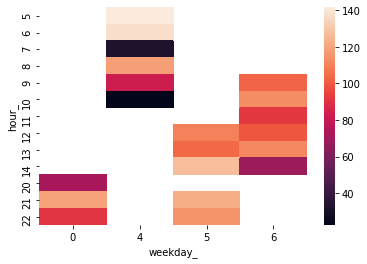

In [9]:
axs=sns.heatmap(dayhourPivot)

### Cluster  origin of tracks using dbscan algorithm

In [10]:
#Get origin and destination of tracks
origin,destination=inspect.OriginAndDestination(track_df)

In [11]:
#Get cluster centers
clusterCentres=inspect.getClusters(origin,3,2)
clusterCentres

clusterId  clusterLat  clusterLon  clusterSize                  geometry
0          0   52.257461     7.62014            2  POINT (7.62014 52.25746)

### Show clusters of track origins with bubblemap

In [12]:
#Show cluster for origin of tracks overlaid with track points
clus=inspect.showClusters(clusterCentres,track_df)
clus